# Network Model

## I - Circuit Elements

We analyze the two circuit elements by computing their input-output response.

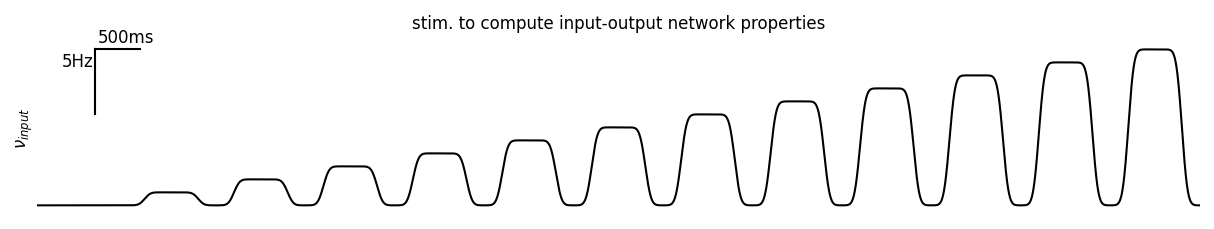

In [1]:
import plot_tools as pt
from src.InputOutput import *
fig, ax = plt.subplots(figsize=(10,1.5))
pt.plot(t, stim, ax=ax)
pt.set_plot(ax, spines=[], xlim=[0,t[-1]], title='stim. to compute input-output network properties', ylabel='$\\nu_{input}$')
pt.draw_bar_scales(ax, Xbar=500, Xbar_label='500ms', Ybar=5, Ybar_label='5Hz')

# quantify output resp at the different levels
def output_resp(rate,
                inter_frac=0.3):
    output = np.zeros(N)
    for e in range(N):
        t0 = e*episode+episode*inter_frac
        t1 = e*episode+episode*(1-inter_frac)
        output[e] = np.mean(rate[(t>t0) & (t<t1)])
    return output

### I-1) Disinhibitory Pathway

see Model properties in [./src/DsnhCircuit.py](./src/DsnhCircuit.py)

Run the simulation with:
```
python src/InputOutput.py Disinhibitory

```

In [2]:
from neural_network_dynamics import ntwk
data = ntwk.recording.load_dict_from_hdf5('data/IO-Dsnh.h5')

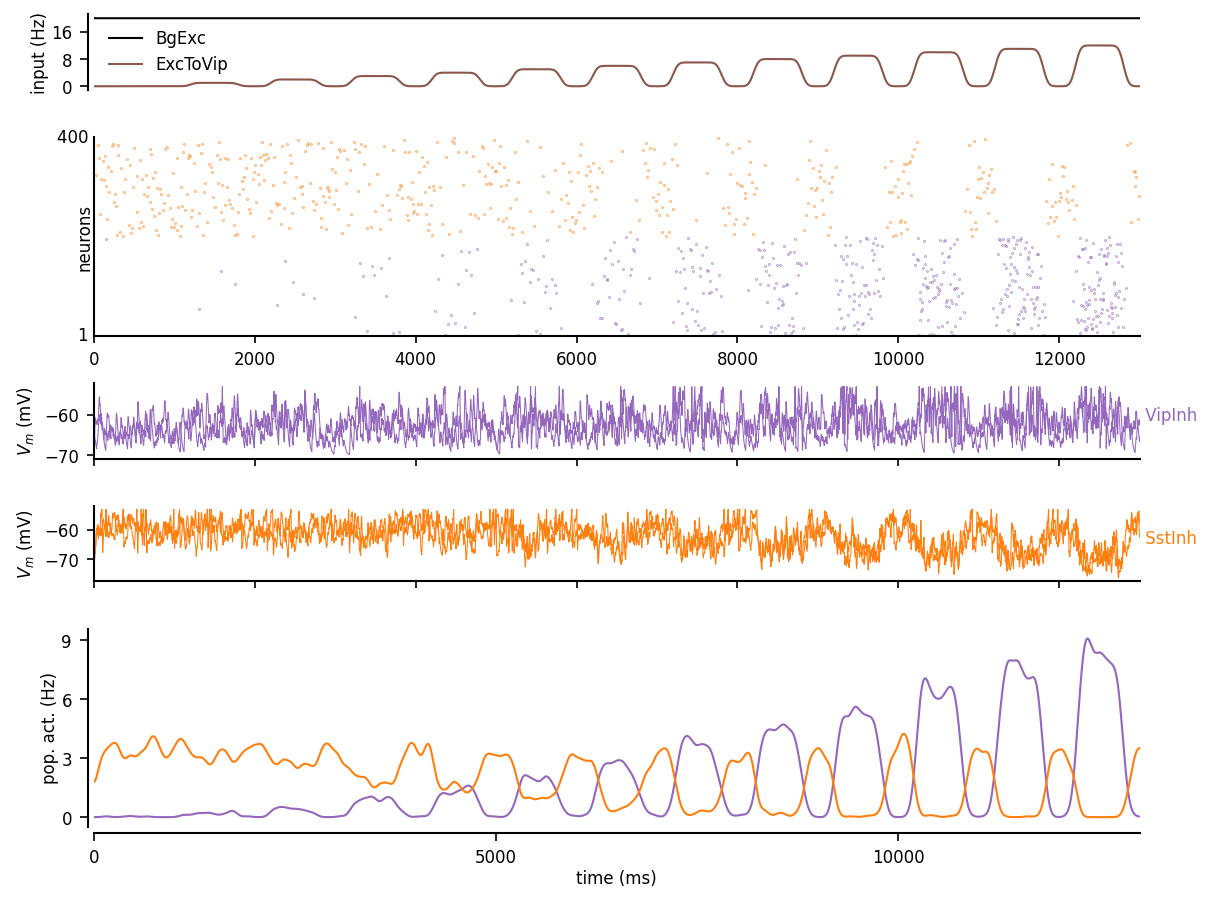

In [3]:
REC_POPS = ['VipInh', 'SstInh']
COLORS = ['tab:purple', 'tab:orange']
fig, _ = ntwk.plots.activity_plots(data, REC_POPS,
                                   COLORS = COLORS,
                                   fig_args=dict(figsize=(1.2,.8)),
                                   pop_act_args=dict(smoothing=50,lw=1),
                                   Vm_args=dict(clip_spikes=True, lw=0.5))

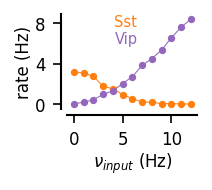

In [4]:
fig, ax = pt.figure()
for i, label, color in zip(range(2), ['Sst','Vip'], ['tab:orange', 'tab:purple']):
    ax.plot(Inputs, output_resp(data['POP_ACT_%sInh' % label]), 'o-', color=color, lw=0.5)
    ax.annotate(i*'\n'+label, (0.45,1), va='top', ha='center', color=color, xycoords='axes fraction', fontsize=7)

pt.set_plot(ax, xlabel='$\\nu_{input}$ (Hz)', ylabel='rate (Hz)')

## I-2) Recurrent Circuit

Run the simulation with:
```
python src/InputOutput.py Recurrent

```

In [5]:
from neural_network_dynamics import ntwk
data = ntwk.recording.load_dict_from_hdf5('data/IO-Rec.h5')

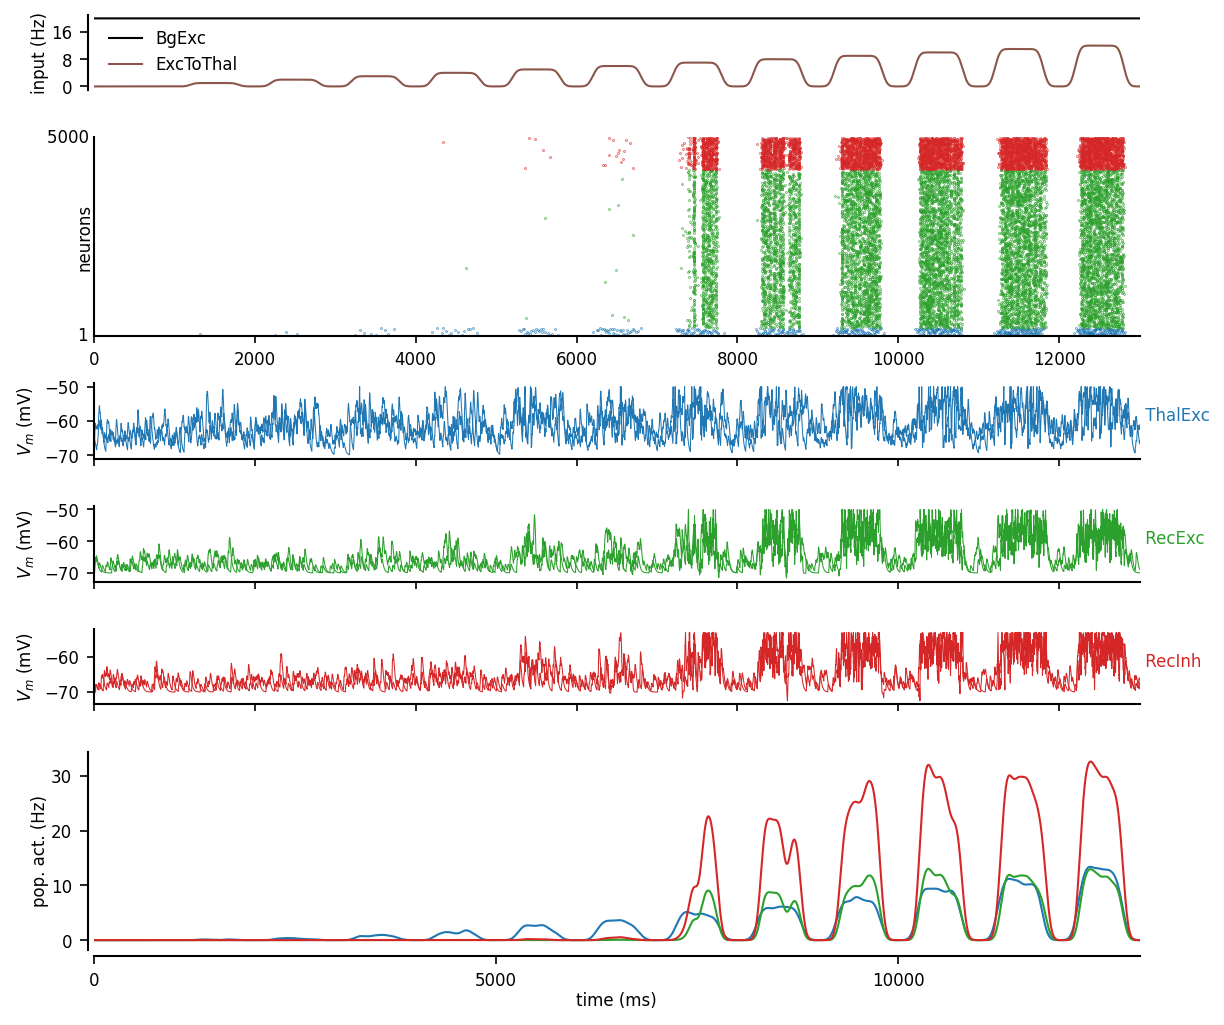

In [6]:
from neural_network_dynamics import ntwk
data = ntwk.recording.load_dict_from_hdf5('data/IO-Rec.h5')
from src.RecCircuit import *
fig, _ = ntwk.plots.activity_plots(data, REC_POPS,
                                   COLORS = COLORS,
                                   fig_args=dict(figsize=(1.2,.8)),
                                   pop_act_args=dict(smoothing=50,lw=1),
                                   Vm_args=dict(clip_spikes=True, lw=0.5))

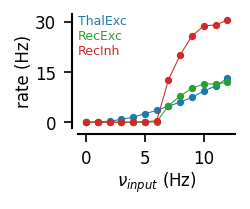

In [7]:
fig, ax = pt.figure(figsize=(1.1,1.2))
for i in range(len(REC_POPS)):
    ax.plot(Inputs, output_resp(data['POP_ACT_%s' % REC_POPS[i]]), 'o-', color=COLORS[i], lw=0.5)
    ax.annotate(i*'\n'+REC_POPS[i], (0.,1), va='top', color=COLORS[i], xycoords='axes fraction', fontsize=6)

pt.set_plot(ax, xlabel='$\\nu_{input}$ (Hz)', ylabel='rate (Hz)')

## II - Coupling the Two Circuit Elements

Run:
```
python src/InputOutput.py Both-Coupled
```

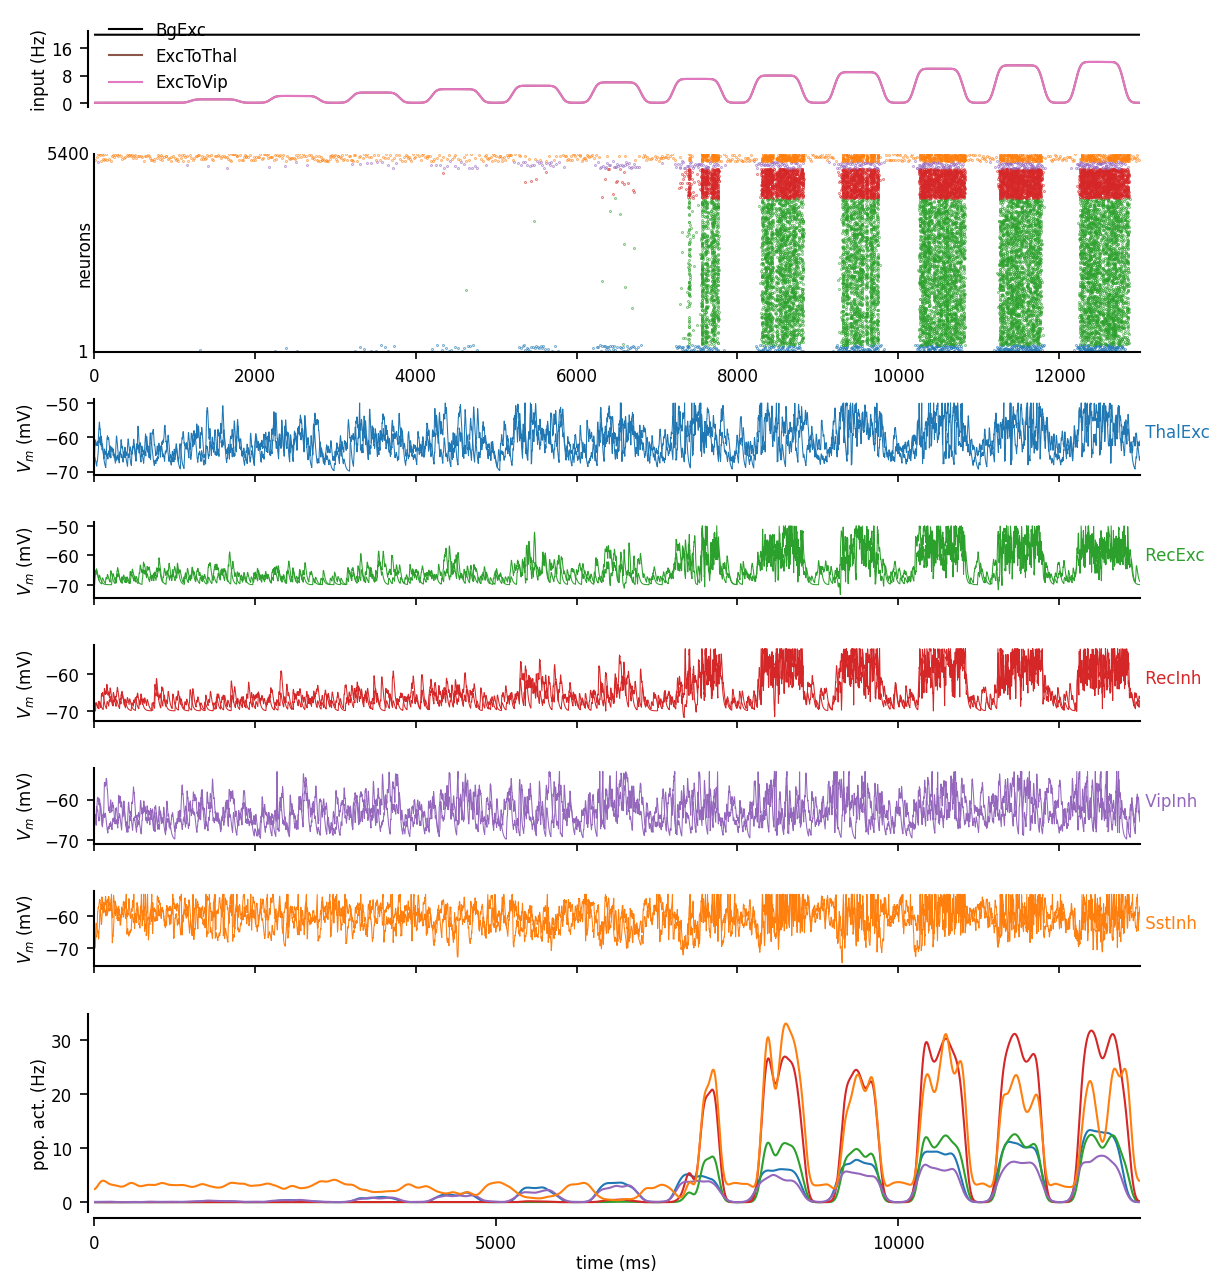

In [9]:
from neural_network_dynamics import ntwk
data = ntwk.recording.load_dict_from_hdf5('data/IO-Both-Coupled.h5')
from src.CoupledCircuit import *
fig, _ = ntwk.plots.activity_plots(data, REC_POPS,
                                   COLORS = COLORS,
                                   fig_args=dict(figsize=(1.2,.8)),
                                   pop_act_args=dict(smoothing=50,lw=1),
                                   Vm_args=dict(clip_spikes=True, lw=0.5))

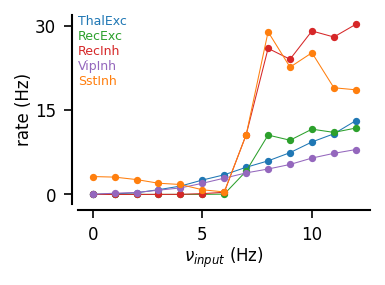

In [11]:
fig, ax = pt.figure(figsize=(1.5,2))
for i in range(len(REC_POPS)):
    ax.plot(Inputs, output_resp(data['POP_ACT_%s' % REC_POPS[i]]), 'o-', color=COLORS[i], lw=0.5)
    ax.annotate(i*'\n'+REC_POPS[i], (0.,1), va='top', color=COLORS[i], xycoords='axes fraction', fontsize=6)

pt.set_plot(ax, xlabel='$\\nu_{input}$ (Hz)', ylabel='rate (Hz)')